In [1]:
from dotenv import load_dotenv

load_dotenv()

False

In [2]:
from typing import TypedDict, Literal, Annotated, List
from operator import add
from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool


class InputState(TypedDict):
    article: str


class OutputState(TypedDict):
    agent_output: str


class OverallState(InputState, OutputState):
    messages: Annotated[List[BaseMessage], add]


@tool
def get_current_club(player_name: str):
    """Gets current club of a player"""
    fake_db = {
        "Lionel Messi": "Paris Saint-Germain",
        "Cristiano Ronaldo": "Al Nassr FC",
    }
    return fake_db.get(player_name, "Current club information not available.")


tools1 = [get_current_club]
model1 = ChatOpenAI(model="gpt-4o-mini").bind_tools(tools1)


def call_model_current_club(state: OverallState):
    local_messages = state.get("messages", [])
    if not local_messages:
        human_message = HumanMessage(content=state["article"])
        local_messages.append(human_message)
    system_message = SystemMessage(
        content="""You are an agent tasked with determining the current club of a player.
If the current club is mentioned, return it. Otherwise, return 'Current club information not available.'"""
    )
    response = model1.invoke([system_message] + local_messages)
    state["agent_output"] = response.content
    state["messages"] = local_messages + [response]
    return state


def should_continue(state: OverallState) -> Literal["tools", END]:
    last_message = state["messages"][-1]
    if getattr(last_message, "tool_calls", None):
        return "tools"
    return END


current_club_graph = StateGraph(OverallState, input=InputState, output=OutputState)
current_club_graph.add_node("call_model_current_club", call_model_current_club)
current_club_graph.add_node("tools", ToolNode(tools1))
current_club_graph.add_edge(START, "call_model_current_club")
current_club_graph.add_conditional_edges("call_model_current_club", should_continue)
current_club_graph.add_edge("tools", "call_model_current_club")

current_club_researcher_agent = current_club_graph.compile()

In [5]:
initial_state = {
    "article": "Lionel Messi will join Real Madrid 2025",
}
current_club_researcher_agent.invoke(initial_state)

{'agent_output': "Lionel Messi's current club is Paris Saint-Germain."}

In [4]:
initial_state = {
    "article": "Thomas Müller will join Real Madrid 2025",
}
current_club_researcher_agent.invoke(initial_state)

{'agent_output': 'Current club information not available.'}

In [6]:
class InputState(TypedDict):
    article: str


class OutputState(TypedDict):
    agent_output: str


class OverallState(InputState, OutputState):
    messages: Annotated[List[BaseMessage], add]


@tool
def get_market_value(player_name: str):
    """Gets current market value of a player"""
    fake_market_value_db = {
        "Lionel Messi": "€50 million",
        "Cristiano Ronaldo": "€30 million",
    }
    return fake_market_value_db.get(
        player_name, "Market value information not available."
    )


tools2 = [get_market_value]
model2 = ChatOpenAI(model="gpt-4o-mini").bind_tools(tools2)


def call_model_market_value(state: OverallState):
    local_messages = state.get("messages", [])
    if not local_messages:
        human_message = HumanMessage(content=state["article"])
        local_messages.append(human_message)
    system_message = SystemMessage(
        content="""You are an agent tasked with determining the market value of a player.
If the market value is mentioned, return it. Otherwise, return 'Market value information not available.'"""
    )
    response = model2.invoke([system_message] + local_messages)
    state["agent_output"] = response.content
    state["messages"] = local_messages + [response]
    return state


def should_continue(state: OverallState) -> Literal["tools", END]:
    last_message = state["messages"][-1]
    if getattr(last_message, "tool_calls", None):
        return "tools"
    return END


market_value_graph = StateGraph(OverallState, input=InputState, output=OutputState)
market_value_graph.add_node("call_model_market_value", call_model_market_value)
market_value_graph.add_node("tools", ToolNode(tools2))
market_value_graph.add_edge(START, "call_model_market_value")
market_value_graph.add_conditional_edges("call_model_market_value", should_continue)
market_value_graph.add_edge("tools", "call_model_market_value")

market_value_researcher_agent = market_value_graph.compile()

In [7]:
market_value_researcher_agent.invoke(
    {"article": "Lionel Messi will switch from FC Barcelona to Real Madrid in 2025"}
)

{'agent_output': 'The market value of Lionel Messi is €50 million.'}

In [8]:
market_value_researcher_agent.invoke(
    {"article": "Thomas Müller will join Real Madrid 2025"}
)

{'agent_output': 'Market value information not available.'}

In [9]:
class InputState(TypedDict):
    article: str


class OutputState(TypedDict):
    agent_output: str


class OverallState(InputState, OutputState):
    pass


model_text_writer = ChatOpenAI(model="gpt-4o-mini")


def expand_text_to_100_words(state: OverallState):
    human_message = HumanMessage(content=state["article"])
    system_message = SystemMessage(
        content="Expand the following text to be at least 100 words. Maintain the original meaning while adding detail."
    )
    response = model_text_writer.invoke([system_message, human_message])
    state["agent_output"] = response.content
    return state


text_writer_graph = StateGraph(OverallState, input=InputState, output=OutputState)
text_writer_graph.add_node("expand_text_to_100_words", expand_text_to_100_words)
text_writer_graph.add_edge(START, "expand_text_to_100_words")
text_writer_graph.add_edge("expand_text_to_100_words", END)

text_writer_agent = text_writer_graph.compile()

In [10]:
text_writer_agent.invoke(
    {"article": "Lionel Messi will switch from FC Barcelona to Real Madrid in 2025"}
)

{'agent_output': "In a surprising turn of events, it has been announced that the legendary Argentine footballer Lionel Messi is set to make a monumental switch from FC Barcelona to their fierce rivals, Real Madrid, in the year 2025. This development has sent shockwaves through the football community, given Messi's long-standing association with Barcelona, where he has spent the majority of his illustrious career. Throughout his time with the Catalan club, he has achieved numerous records, won multiple Ballon d'Or awards, and has become an icon of the sport. The potential transfer to Real Madrid, a club known for its storied history and fierce competition, will undoubtedly change the landscape of modern football and ignite intense debates among fans and analysts alike. This transfer could mark a new chapter in Messi's career, as he seeks to further his legacy in one of the most competitive leagues in the world."}

### Supervisor Agent

In [11]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field


class ArticlePostabilityGrader(BaseModel):
    """Binary scores for verifying if an article mentions market value, current club, and meets the minimum word count of 100 words."""

    off_or_ontopic: str = Field(
        description="The Article is about football transfers, 'yes' or 'no'"
    )
    mentions_market_value: str = Field(
        description="The article mentions the player's market value, 'yes' or 'no'"
    )
    mentions_current_club: str = Field(
        description="The article mentions the player's current club, 'yes' or 'no'"
    )
    meets_100_words: str = Field(
        description="The article has at least 100 words, 'yes' or 'no'"
    )


llm_postability = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_postability_grader = llm_postability.with_structured_output(
    ArticlePostabilityGrader
)

postability_system = """
You are a grader assessing whether a news article meets the following criteria:
1. The article is about football transfers or not. If yes answer, answer with 'yes', anotherwise with 'no'.
1. The article explicitly mentions the player's market value, for example, by stating "market value" or a specific currency amount (e.g., "$50 million"). If this is present, respond with 'yes' for mentions_market_value; otherwise, respond 'no'.
2. The article mentions the player's current club or indicates that the current club information is unavailable (e.g., "Current club information not available"). If this is present, respond with 'yes' for mentions_current_club; otherwise, respond 'no'.
3. The article contains at least 100 words. If this is met, respond with 'yes' for meets_100_words; otherwise, respond 'no'.

Provide four binary scores ('yes' or 'no') as follows:
- off_or_ontopic: 'yes' or 'no' depending on whether the article is related to football transfers or not.
- mentions_market_value: 'yes' or 'no' depending on whether the article mentions the player's market value.
- mentions_current_club: 'yes' or 'no' depending on whether the article mentions the player's current club or states that the information is unavailable.
- meets_100_words: 'yes' or 'no' depending on whether the article has at least 100 words.
"""

postability_grade_prompt = ChatPromptTemplate.from_messages(
    [("system", postability_system), ("human", "News Article:\n\n{article}")]
)

news_chef = postability_grade_prompt | structured_llm_postability_grader

In [12]:
news_chef.invoke({"article": "Lionel Messi will switch to Real Madrid in 2025"})

ArticlePostabilityGrader(off_or_ontopic='yes', mentions_market_value='no', mentions_current_club='no', meets_100_words='no')

In [13]:
news_chef.invoke({"article": "Today in Munich will be 9°C"})

ArticlePostabilityGrader(off_or_ontopic='no', mentions_market_value='no', mentions_current_club='no', meets_100_words='no')

### Workflow

In [14]:
from typing import TypedDict, Literal
from langgraph.graph import END, StateGraph


class InputArticleState(TypedDict):
    article: str


class OutputFinalArticleState(TypedDict):
    final_article: str
    off_or_ontopic: str


class SharedArticleState(InputArticleState, OutputFinalArticleState):
    mentions_market_value: str
    mentions_current_club: str
    meets_100_words: str


def update_article_state(state: SharedArticleState) -> SharedArticleState:
    response = news_chef.invoke({"article": state["article"]})
    state["off_or_ontopic"] = response.off_or_ontopic
    state["mentions_market_value"] = response.mentions_market_value
    state["mentions_current_club"] = response.mentions_current_club
    state["meets_100_words"] = response.meets_100_words
    print("State after update_article_state:", state)
    return state


def market_value_researcher_node(state: SharedArticleState) -> SharedArticleState:
    response = market_value_researcher_agent.invoke({"article": state["article"]})
    state["article"] += f" {response['agent_output']}"
    return state


def current_club_researcher_node(state: SharedArticleState) -> SharedArticleState:
    response = current_club_researcher_agent.invoke({"article": state["article"]})
    state["article"] += f" {response['agent_output']}"
    return state


def word_count_rewriter_node(state: SharedArticleState) -> SharedArticleState:
    response = text_writer_agent.invoke({"article": state["article"]})
    state["article"] += f" {response['agent_output']}"
    state["final_article"] = response["agent_output"]
    return state


def news_chef_decider(
    state: SharedArticleState,
) -> Literal[
    "market_value_researcher", "current_club_researcher", "word_count_rewriter", END
]:
    if state["off_or_ontopic"] == "no":
        return END
    if state["mentions_market_value"] == "no":
        return "market_value_researcher"
    elif state["mentions_current_club"] == "no":
        return "current_club_researcher"
    elif (
        state["meets_100_words"] == "no"
        and state["mentions_market_value"] == "yes"
        and state["mentions_current_club"] == "yes"
    ):
        return "word_count_rewriter"
    else:
        return END


workflow = StateGraph(
    SharedArticleState, input=InputArticleState, output=OutputFinalArticleState
)

workflow.add_node("news_chef", update_article_state)
workflow.add_node("market_value_researcher", market_value_researcher_node)
workflow.add_node("current_club_researcher", current_club_researcher_node)
workflow.add_node("word_count_rewriter", word_count_rewriter_node)

workflow.set_entry_point("news_chef")

workflow.add_conditional_edges(
    "news_chef",
    news_chef_decider,
    {
        "market_value_researcher": "market_value_researcher",
        "current_club_researcher": "current_club_researcher",
        "word_count_rewriter": "word_count_rewriter",
        END: END,
    },
)

workflow.add_edge("market_value_researcher", "news_chef")
workflow.add_edge("current_club_researcher", "news_chef")
workflow.add_edge("word_count_rewriter", "news_chef")

app = workflow.compile()

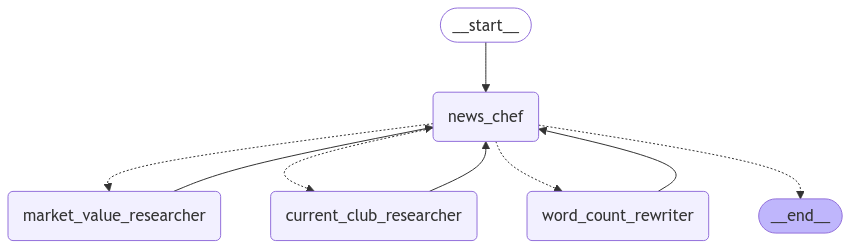

In [15]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [16]:
app.invoke({"article": "Today in Munich will be 9°C"})

State after update_article_state: {'article': 'Today in Munich will be 9°C', 'off_or_ontopic': 'no', 'mentions_market_value': 'no', 'mentions_current_club': 'no', 'meets_100_words': 'no'}


{'off_or_ontopic': 'no'}

In [17]:
app.invoke({"article": "Lionel Messi will to Real Madrid in 2025"})

State after update_article_state: {'article': 'Lionel Messi will to Real Madrid in 2025', 'off_or_ontopic': 'yes', 'mentions_market_value': 'no', 'mentions_current_club': 'no', 'meets_100_words': 'no'}
State after update_article_state: {'article': 'Lionel Messi will to Real Madrid in 2025 The market value of Lionel Messi is €50 million.', 'off_or_ontopic': 'yes', 'mentions_market_value': 'yes', 'mentions_current_club': 'no', 'meets_100_words': 'no'}
State after update_article_state: {'article': "Lionel Messi will to Real Madrid in 2025 The market value of Lionel Messi is €50 million. Lionel Messi's current club is Paris Saint-Germain.", 'off_or_ontopic': 'yes', 'mentions_market_value': 'yes', 'mentions_current_club': 'yes', 'meets_100_words': 'no'}
State after update_article_state: {'article': "Lionel Messi will to Real Madrid in 2025 The market value of Lionel Messi is €50 million. Lionel Messi's current club is Paris Saint-Germain. As of October 2023, Lionel Messi is an immensely tal

{'final_article': "As of October 2023, Lionel Messi is an immensely talented football player whose skills and contributions to the sport are widely recognized. Currently, he plays for Paris Saint-Germain (PSG), where he has continued to showcase his extraordinary abilities on the field. Reports indicate that Messi may be considering a transfer to Real Madrid by the year 2025, a move that would certainly create a significant buzz in the football community, given the historical rivalry between PSG and Real Madrid. At present, Messi's market value is estimated at an impressive €50 million, reflecting his status as one of the premier athletes in the world of football. His career has been marked by numerous accolades, and fans eagerly anticipate what the future holds for him as he navigates the latter stages of his illustrious career. The possibility of him joining Real Madrid adds an exciting layer to the ongoing narrative of his professional journey.",
 'off_or_ontopic': 'yes'}

### Add Human in the Loop

In [18]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()


class InputState(TypedDict):
    question: str


class IntermediateState(InputState):
    off_or_ontopic: str
    answer: str


class FinalState(IntermediateState):
    api_response: str
    status_code: int

In [19]:
def input_node(state: InputState) -> InputState:
    return state


def newsagent_node(state: IntermediateState) -> IntermediateState:
    response = app.invoke({"article": state["question"]})
    state["answer"] = response.get(
        "final_article", "Article not relevant for news agency"
    )
    state["off_or_ontopic"] = response["off_or_ontopic"]
    return state


def api_call_node(state: FinalState) -> FinalState:
    state["status_code"] = 200
    state["api_response"] = f"API received answer: {state['answer']}"
    return state

In [20]:
workflow = StateGraph(FinalState, input=InputState, output=FinalState)

workflow.add_node("newsagent_node", newsagent_node)
workflow.add_node("api_call_node", api_call_node)

workflow.set_entry_point("newsagent_node")

workflow.add_edge("newsagent_node", "api_call_node")
workflow.add_edge("api_call_node", END)

In [21]:
human_app = workflow.compile(
    checkpointer=checkpointer, interrupt_after=["newsagent_node"]
)

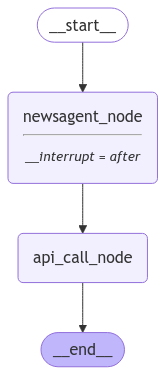

In [22]:
from IPython.display import Image, display

try:
    display(Image(human_app.get_graph().draw_mermaid_png()))
except Exception:
    pass

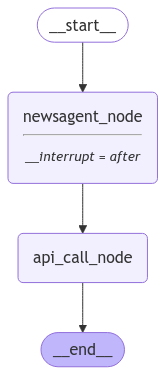

In [23]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        human_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [24]:
config = {"configurable": {"thread_id": "1"}}
config2 = {"configurable": {"thread_id": "2"}}

In [25]:
human_app.invoke(
    {"question": "The weather will be 9°C in Munich"}, config=config2, subgraphs=True
)

State after update_article_state: {'article': 'The weather will be 9°C in Munich', 'off_or_ontopic': 'no', 'mentions_market_value': 'no', 'mentions_current_club': 'no', 'meets_100_words': 'no'}


((),
 {'question': 'The weather will be 9°C in Munich',
  'off_or_ontopic': 'no',
  'answer': 'Article not relevant for news agency'})

In [26]:
human_app.invoke(
    {"question": "Lionel Messi will to Real Madrid in 2025"},
    config=config,
    subgraphs=True,
)

State after update_article_state: {'article': 'Lionel Messi will to Real Madrid in 2025', 'off_or_ontopic': 'yes', 'mentions_market_value': 'no', 'mentions_current_club': 'no', 'meets_100_words': 'no'}
State after update_article_state: {'article': 'Lionel Messi will to Real Madrid in 2025 The market value of Lionel Messi is €50 million.', 'off_or_ontopic': 'yes', 'mentions_market_value': 'yes', 'mentions_current_club': 'no', 'meets_100_words': 'no'}
State after update_article_state: {'article': "Lionel Messi will to Real Madrid in 2025 The market value of Lionel Messi is €50 million. Lionel Messi's current club is Paris Saint-Germain.", 'off_or_ontopic': 'yes', 'mentions_market_value': 'yes', 'mentions_current_club': 'yes', 'meets_100_words': 'no'}
State after update_article_state: {'article': "Lionel Messi will to Real Madrid in 2025 The market value of Lionel Messi is €50 million. Lionel Messi's current club is Paris Saint-Germain. As of October 2023, it is anticipated that the legen

((),
 {'question': 'Lionel Messi will to Real Madrid in 2025',
  'off_or_ontopic': 'yes',
  'answer': "As of October 2023, it is anticipated that the legendary Argentine footballer Lionel Messi may potentially make a move to Real Madrid in the year 2025. This speculation arises amidst ongoing discussions about his future in professional football. Currently, Messi's market value stands at an impressive €50 million, reflecting his status as one of the most talented and sought-after players in the sport. Presently, Messi is playing for Paris Saint-Germain (PSG), where he has continued to showcase his extraordinary skills and contribute significantly to the team's performance. His time at PSG has been marked by numerous achievements and memorable moments, but the possibility of him wearing the iconic white jersey of Real Madrid adds an intriguing layer to his career narrative and the ever-evolving landscape of football transfers."})

In [27]:
snapshot = human_app.get_state(config2)
snapshot.next

('api_call_node',)

In [28]:
human_app.invoke(None, config=config2)

{'question': 'The weather will be 9°C in Munich',
 'off_or_ontopic': 'no',
 'answer': 'Article not relevant for news agency',
 'api_response': 'API received answer: Article not relevant for news agency',
 'status_code': 200}

In [29]:
snapshot = human_app.get_state(config)
snapshot.next

('api_call_node',)

In [30]:
snapshot = human_app.get_state(config)
existing_message = snapshot.values
existing_message

{'question': 'Lionel Messi will to Real Madrid in 2025',
 'off_or_ontopic': 'yes',
 'answer': "As of October 2023, it is anticipated that the legendary Argentine footballer Lionel Messi may potentially make a move to Real Madrid in the year 2025. This speculation arises amidst ongoing discussions about his future in professional football. Currently, Messi's market value stands at an impressive €50 million, reflecting his status as one of the most talented and sought-after players in the sport. Presently, Messi is playing for Paris Saint-Germain (PSG), where he has continued to showcase his extraordinary skills and contribute significantly to the team's performance. His time at PSG has been marked by numerous achievements and memorable moments, but the possibility of him wearing the iconic white jersey of Real Madrid adds an intriguing layer to his career narrative and the ever-evolving landscape of football transfers."}

In [31]:
human_app.update_state(
    config,
    {"answer": "Fake news!!!"},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe9777-8bed-6478-8002-ecd18edcdba4'}}

In [32]:
human_app.invoke(None, config=config)

{'question': 'Lionel Messi will to Real Madrid in 2025',
 'off_or_ontopic': 'yes',
 'answer': 'Fake news!!!',
 'api_response': 'API received answer: Fake news!!!',
 'status_code': 200}

In [33]:
snapshot = human_app.get_state(config)
snapshot.next

()